In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, make_scorer

In [50]:
PATH_DATA = '../data/data/'
PATH_IMAGES = '../assets/images/confusion/'
PATH_RESULTS = '../results/'

## Loading the data

In [158]:
# training set
train = pd.read_csv(PATH_DATA + "CRC_3200_train.csv")
X_train = train.drop(['lemmas', 'tag', 'bin_tag'], axis=1)
y_train = train['tag'].copy()

In [159]:
# test set (CRC)
test_CRC = pd.read_csv(PATH_DATA + "CRC_800_test.csv")
X_test_CRC = test_CRC.drop(['lemmas', 'tag', 'bin_tag'], axis=1)
y_test_CRC = test_CRC['tag'].copy()

In [147]:
# test set (C3)
test_c3 = pd.read_csv(PATH_DATA + "C3_12000.csv")
X_test_c3 = test_c3.drop(['lemmas', 'bin_tag'], axis=1)
y_test_bin_c3 = test_c3['bin_tag'].copy()

In [148]:
# test set (YNACC)
test_ynacc = pd.read_csv(PATH_DATA + "YNACC.csv")
X_test_ynacc = test_ynacc.drop(['lemmas', 'bin_tag', 'named_entities'], axis=1)
X_test_ynacc.fillna(0, inplace=True)
y_test_bin_ynacc = test_ynacc['bin_tag'].copy()

## Gradient Boosting

In [160]:
clf = GradientBoostingClassifier(n_estimators=300,
                                  learning_rate=0.03,
                                  max_depth=8,
                                  validation_fraction=0.1,
                                  n_iter_no_change=5, tol=0.005,
                                  random_state=0,
                                  verbose=1)

### All features - Multiclass

In [161]:
trans = ColumnTransformer(transformers=[
            ('review', TfidfVectorizer(min_df=1, max_df=0.1, encoding='utf-8', ngram_range=(1,1)), 'text_review'),
            ('pos', TfidfVectorizer(encoding='utf-8', ngram_range=(1,1)), 'text_pos'),
            ],
                         remainder='passthrough')

In [162]:
pipeline = Pipeline([
    ('union', trans)
])

In [163]:
X_train_fitted = pipeline.fit_transform(X_train)
X_test_CRC_fitted = pipeline.transform(X_test_CRC)
#X_test_c3_fitted = pipeline.transform(X_test_c3)
#X_test_ynacc_fitted = pipeline.transform(X_test_ynacc)

print('Size of the feature matrix for CRC:', X_test_CRC_fitted.shape)
#print('Size of the feature matrix for C3:', X_test_c3_fitted.shape)
#print('Size of the feature matrix for YNACC:', X_test_ynacc_fitted.shape)

Size of the feature matrix for CRC: (800, 13733)


In [164]:
clf.fit(X_train_fitted, y_train)

      Iter       Train Loss   Remaining Time 
         1        3533.5266            3.03m
         2        3396.8347            3.07m
         3        3273.8531            3.14m
         4        3161.0982            3.16m
         5        3057.9432            3.15m
         6        2962.7712            3.16m
         7        2873.8658            3.16m
         8        2791.6650            3.15m
         9        2714.9806            3.14m
        10        2642.1705            3.15m
        20        2097.1597            3.05m
        30        1715.3270            2.90m
        40        1440.2453            2.79m
        50        1250.7845            2.67m
        60        1111.9144            2.52m
        70        1007.9074            2.38m
        80         921.2939            2.25m
        90         849.9142            2.13m
       100         790.3963            1.99m


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.03, loss='deviance', max_depth=8,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=5, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.005,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

Accuracy: 0.69125
F1 Score: 0.6882558070553167
              precision    recall  f1-score   support

           0       0.68      0.47      0.56       108
           1       0.70      0.73      0.71       280
           2       0.67      0.73      0.70       300
           3       0.74      0.70      0.72       112

    accuracy                           0.69       800
   macro avg       0.70      0.66      0.67       800
weighted avg       0.69      0.69      0.69       800



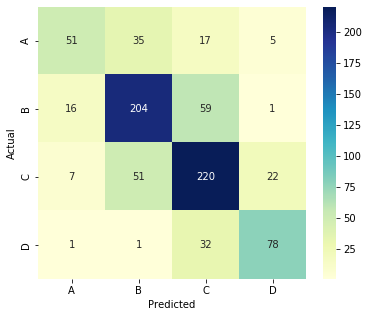

In [165]:
y_pred = clf.predict(X_test_CRC_fitted)
print("Accuracy:", accuracy_score(y_test_CRC, y_pred))
print("F1 Score:", f1_score(y_test_CRC, y_pred, average='weighted'))
print(classification_report(y_test_CRC, y_pred))
report = classification_report(y_test_CRC, y_pred, output_dict=True)
#pd.DataFrame(report).transpose().to_csv(PATH_RESULTS+'bin-GBM-C3-entities.csv', index=False)

conf_mat = confusion_matrix(y_test_CRC, y_pred)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(conf_mat, cmap="YlGnBu", annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set_xticklabels(['A', 'B', 'C', 'D'])
ax.set_yticklabels(['A', 'B', 'C', 'D'])
#plt.savefig(PATH_IMAGES+'multi-GBM-CRC-allbutdiscourse.png', bbox_inches='tight')
plt.show()

In [167]:
clf.predict(pipeline.transform('this item sucks'))

ValueError: Expected 2D array, got scalar array instead:
array=this item sucks.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [59]:
# Misclassified examples for GBM with all features in multiclass setting

#for i, j, k in zip(X_test_CRC.text_review, y_test_CRC, y_pred):
#    if k-j > 1 or j-k > 1:
#        print("REVIEW:", i, "GOLD", j, "PREDICTED:", k, "\n")

REVIEW: why people think that they need these has always been a mystery ... as if sony microsoft nintendo do not stress test their systems and efficiently tune the stock cooling fansthis is clearly a product that nobody really needs GOLD 0 PREDICTED: 2 

REVIEW: bought the ir3bu model a couple years ago and has been returned twicw for repair and now the menu system is in chinese which is not a problem as it is broke down again i would spend the three hundred on another scout camera before buying another of these GOLD 0 PREDICTED: 2 

REVIEW: sorry billy but more compilations like this are only driving fans away there is absolutely nothing here that has not already been rehashed ten times over yet another horrendous disappointment GOLD 0 PREDICTED: 2 

REVIEW: the heads are carbide but the shanks are soft steel the shank diameter is 3mm not 1/8 as advertised the 3mm shank will not chuck up in a proper 1/8 die grinder it may chuck up in a cheep electric dremel tool or equivalent but not 